In [1]:
%load_ext load_style
%load_style talk.css
from IPython.display import YouTubeVideo, Image

# [XRAY](https://github.com/xray/xray)

[xray](https://github.com/xray/xray) has been developed by scientists / engineers working at the [Climate Corporation](http://climate.com/)

It is an open source project and Python package that aims to bring
the labeled data power of [pandas](http://pandas.pydata.org) to the
physical sciences, by providing N-dimensional variants of the core
[pandas](http://pandas.pydata.org) data structures, `Series` and
`DataFrame`: the xray `DataArray` and `Dataset`.

the goal is to provide a pandas-like and pandas-compatible toolkit for
analytics on multi-dimensional arrays, rather than the tabular data for
which pandas excels. The approach adopts the [Common Data
Model](http://www.unidata.ucar.edu/software/thredds/current/netcdf-java/CDM)
for self-describing scientific data in widespread use in the Earth
sciences (e.g., [netCDF](http://www.unidata.ucar.edu/software/netcdf)
and [OPeNDAP](http://www.opendap.org/)): `xray.Dataset` is an in-memory
representation of a netCDF file.

-   HTML documentation: <http://xray.readthedocs.org>: **really good doc !**
-   Source code: <http://github.com/xray/xray>

The main advantages of using [xray](https://github.com/xray/xray) versus [netCDF4](https://github.com/Unidata/netcdf4-python) are: 

+ intelligent selection along **labelled dimensions** (and also indexes)
+ **groupby** operations ! 
+ data alignment 
+ IO (netcdf)
+ conversion from / to [Pandas.DataFrames](http://pandas.pydata.org/pandas-docs/dev/generated/pandas.DataFrame.html)

What is missing IMHO: 

*+ Multiple File Datasets (see netCDF4 [MFDataset](http://netcdf4-python.googlecode.com/svn/trunk/docs/netCDF4.MFDataset-class.html))*

<font color='red'><b>UPDATE !</b> (Thanks Stephan Hoyer!) you can open multiple files Datasets using `glob` and the `concat` method</font>: 

```python
import glob
import xray 

files = sorted(glob.glob('/Users/nicolasf/data/NCEP1/PAC/hgt.????.nc'))

ds = xray.concat([xray.open_dataset(f) for f in files], 'time')
```

You can now use the `sel` method to select slices along e.g. the time dimension: 

```python 

ds.sel(time=slice('1980','2000'))

```

To install the latest version of xray: 

```
ᐅ pip install https://github.com/xray/xray/archive/master.zip
```

There's too much to see in the context of this talk, to know more about all the cool **xray** features, watch: 

PyData talk by **Stefan Hoyer**: <https://www.youtube.com/watch?v=T5CZyNwBa9c>

In [3]:
YouTubeVideo('T5CZyNwBa9c', width=500, height=400, start=0)

## Some examples

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
import os
import numpy as np
import pandas as pd
from mpl_toolkits.basemap import Basemap as bm

In [4]:
import xray; print(xray.__version__)

0.4.1.dev


### Open a netcdf file (ERSST Version 4)

In [5]:
dset = xray.open_dataset('../data/ersst.realtime.nc')

dset is a [xray.Dataset](http://xray.readthedocs.org/en/stable/data-structures.html#dataset), It is a dict-like container of labeled arrays (DataArray objects) with aligned dimensions. It is designed as an in-memory representation of the data model from the netCDF file format.

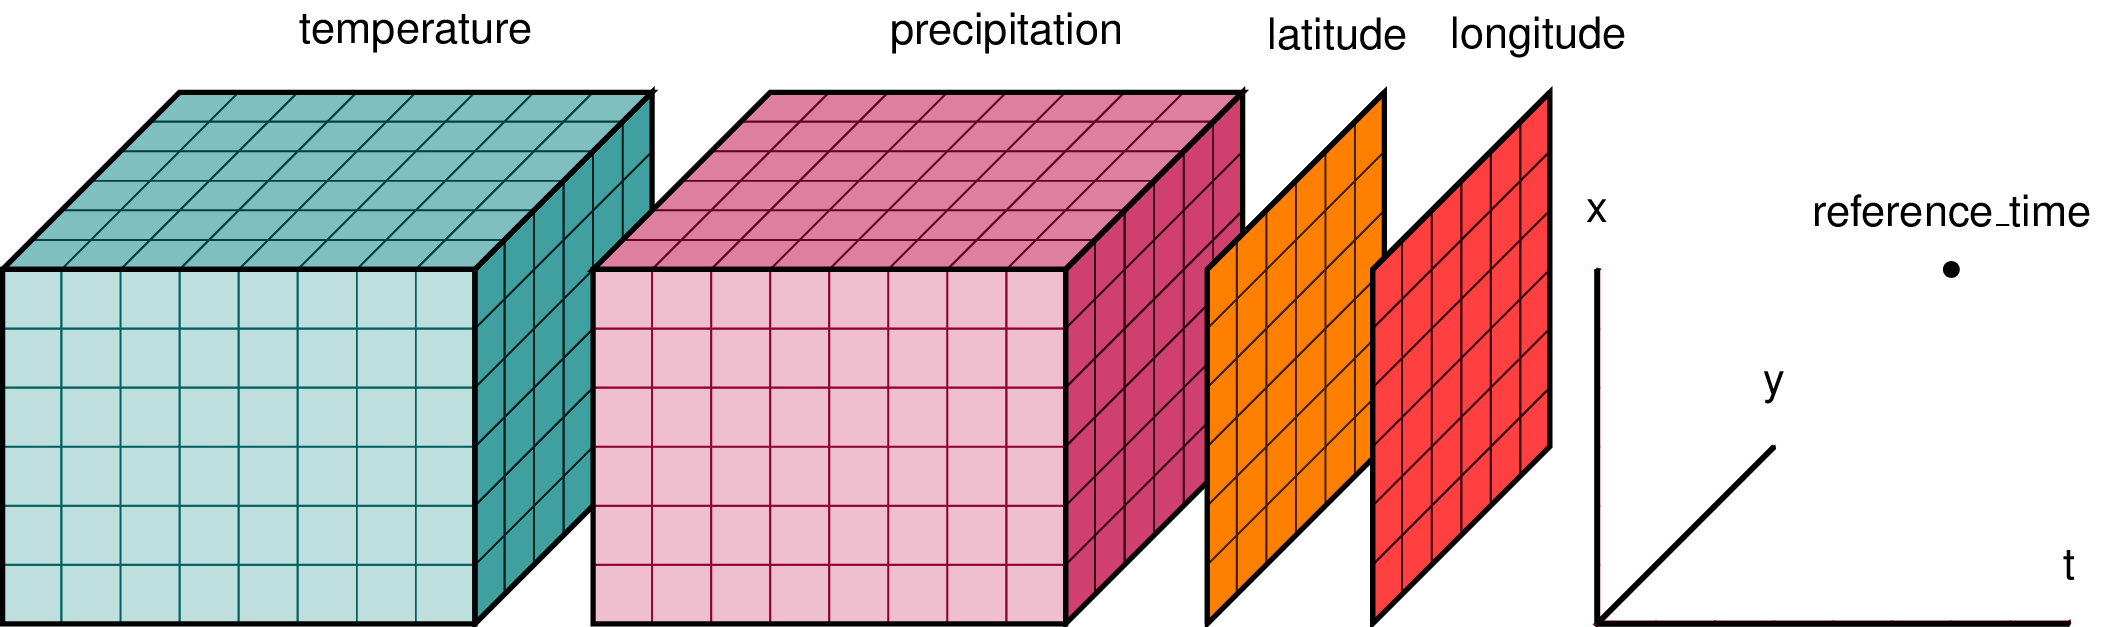

In [7]:
Image('http://xray.readthedocs.org/en/stable/_images/dataset-diagram.png', width=700)

In [8]:
dset

<xray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 806, zlev: 1)
Coordinates:
  * time     (time) datetime64[ns] 1948-02-15 1948-03-15 1948-04-15 1948-05-15 1948-06-15 ...
  * zlev     (zlev) float32 0.0
  * lat      (lat) float32 -88.0 -86.0 -84.0 -82.0 -80.0 -78.0 -76.0 -74.0 -72.0 -70.0 -68.0 ...
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 10.0 12.0 14.0 16.0 18.0 20.0 22.0 24.0 26.0 28.0 ...
Data variables:
    sst      (time, zlev, lat, lon) float64 nan nan nan nan nan nan nan nan nan nan nan nan nan ...
    anom     (time, zlev, lat, lon) float64 nan nan nan nan nan nan nan nan nan nan nan nan nan ...
    err      (time, zlev, lat, lon) float64 nan nan nan nan nan nan nan nan nan nan nan nan nan ...
Attributes:
    title: ERSST V3b in situ only
    history: Wed Apr  8 09:45:04 2015: /usr/local/bin/ncrcat -O ersst.194802_ft.nc ersst.194803_ft.nc ersst.194804_ft.nc ersst.194805_ft.nc ersst.194806_ft.nc ersst.194807_ft.nc ersst.194808_ft.nc ersst.194809_ft.nc ersst.194810_ft.n

In [9]:
dset.dims.keys()

[u'lat', u'lon', u'time', u'zlev']

In [10]:
dset.dims

Frozen(SortedKeysDict({u'lat': 89, u'zlev': 1, u'lon': 180, u'time': 806}))

In [11]:
dset.attrs.keys()

[u'title',
 u'history',
 u'creation_date',
 u'description',
 u'source',
 u'contact',
 u'Conventions',
 u'nco_openmp_thread_number']

In [12]:
dset.keys()

[u'time', u'zlev', u'lat', u'lon', u'sst', u'anom', u'err']

### accessing variables

In [13]:
lat = dset['lat']

In [18]:
type(lat)

xray.core.dataarray.DataArray

In [19]:
lat = dset['lat']
lon = dset['lon']
lons, lats = np.meshgrid(lon, lat)

### selecting a Dataset along dimensions

In [21]:
dset.sel(time=('1998-1-15'), zlev=0)

<xray.Dataset>
Dimensions:  (lat: 89, lon: 180)
Coordinates:
    time     datetime64[ns] 1998-01-15
    zlev     float32 0.0
  * lat      (lat) float32 -88.0 -86.0 -84.0 -82.0 -80.0 -78.0 -76.0 -74.0 -72.0 -70.0 -68.0 ...
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 10.0 12.0 14.0 16.0 18.0 20.0 22.0 24.0 26.0 28.0 ...
Data variables:
    sst      (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan ...
    anom     (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan ...
    err      (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan ...
Attributes:
    title: ERSST V3b in situ only
    history: Wed Apr  8 09:45:04 2015: /usr/local/bin/ncrcat -O ersst.194802_ft.nc ersst.194803_ft.nc ersst.194804_ft.nc ersst.194805_ft.nc ersst.194806_ft.nc ersst.194807_ft.nc ersst.194808_ft.nc ersst.194809_ft.nc ersst.194810_ft.nc ersst.194811_ft.nc ersst.194812_ft.nc ersst.194901_ft.nc ersst.194902_ft.nc erss

In [28]:
dset.sel(time=slice('1998-1-15','2000-12-15'), zlev=0, lat=slice(-40,40))

<xray.Dataset>
Dimensions:  (lat: 41, lon: 180, time: 36)
Coordinates:
  * time     (time) datetime64[ns] 1998-01-15 1998-02-15 1998-03-15 1998-04-15 1998-05-15 ...
    zlev     float32 0.0
  * lat      (lat) float32 -40.0 -38.0 -36.0 -34.0 -32.0 -30.0 -28.0 -26.0 -24.0 -22.0 -20.0 ...
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 10.0 12.0 14.0 16.0 18.0 20.0 22.0 24.0 26.0 28.0 ...
Data variables:
    sst      (time, lat, lon) float64 13.89 13.81 13.72 13.61 13.56 13.89 14.87 16.25 17.42 ...
    anom     (time, lat, lon) float64 -0.4 -0.47 -0.56 -0.72 -0.89 -0.9 -0.63 -0.29 -0.2 -0.43 ...
    err      (time, lat, lon) float64 0.35 0.33 0.26 0.26 0.3 0.31 0.2 0.18 0.32 0.44 0.5 0.47 ...
Attributes:
    title: ERSST V3b in situ only
    history: Wed Apr  8 09:45:04 2015: /usr/local/bin/ncrcat -O ersst.194802_ft.nc ersst.194803_ft.nc ersst.194804_ft.nc ersst.194805_ft.nc ersst.194806_ft.nc ersst.194807_ft.nc ersst.194808_ft.nc ersst.194809_ft.nc ersst.194810_ft.nc ersst.194811_ft.nc er

#### defines the Basemap projection

In [22]:
m = bm(projection='cyl',llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360,\
            lat_ts=0,resolution='c')

#### defines a function to plot a field (must be 2D)

In [24]:
def plot_field(X, lat, lon, vmin, vmax, step, cmap=plt.get_cmap('jet'), ax=False, title=False, grid=False):
    if not ax: 
        f, ax = plt.subplots(figsize=(10, (X.shape[0] / float(X.shape[1])) * 10))
    m.ax = ax
    im = m.contourf(lons, lats, X, np.arange(vmin, vmax+step, step), latlon=True, cmap=cmap, extend='both', ax=ax)
    m.drawcoastlines()
    if grid: 
        m.drawmeridians(np.arange(0, 360, 60), labels=[0,0,0,1])
        m.drawparallels([-40, 0, 40], labels=[1,0,0,0])
    m.colorbar(im)
    if title: 
        ax.set_title(title)

#### plots 

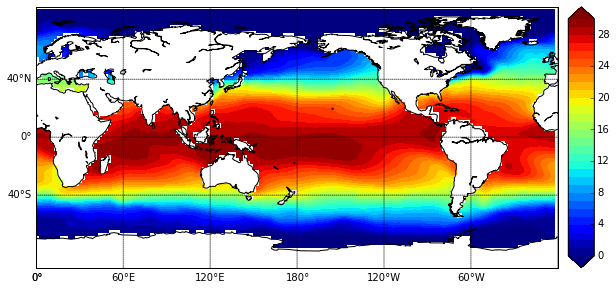

In [25]:
plot_field(dset.sel(time=('1998-1-15'), zlev=0)['sst'], lats, lons, 0, 30, 1, grid=True)

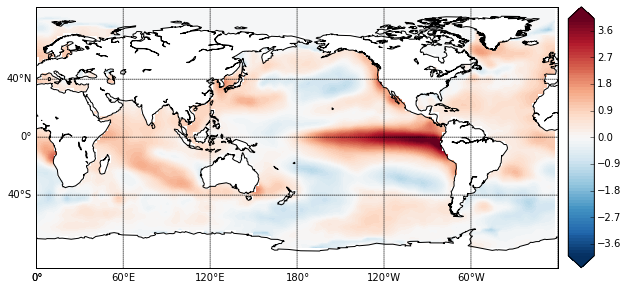

In [26]:
plot_field(dset.sel(time=('1998-1-15'), zlev=0)['anom'], lats, lons, -4, 4, 0.1, \
           cmap=plt.get_cmap('RdBu_r'), grid=True)

In [31]:
mat = dset.sel(lon=slice(0, 10), time=('1998-1-15'), zlev=0)['sst']

### calculates a monthly climatology using the groupby machinery

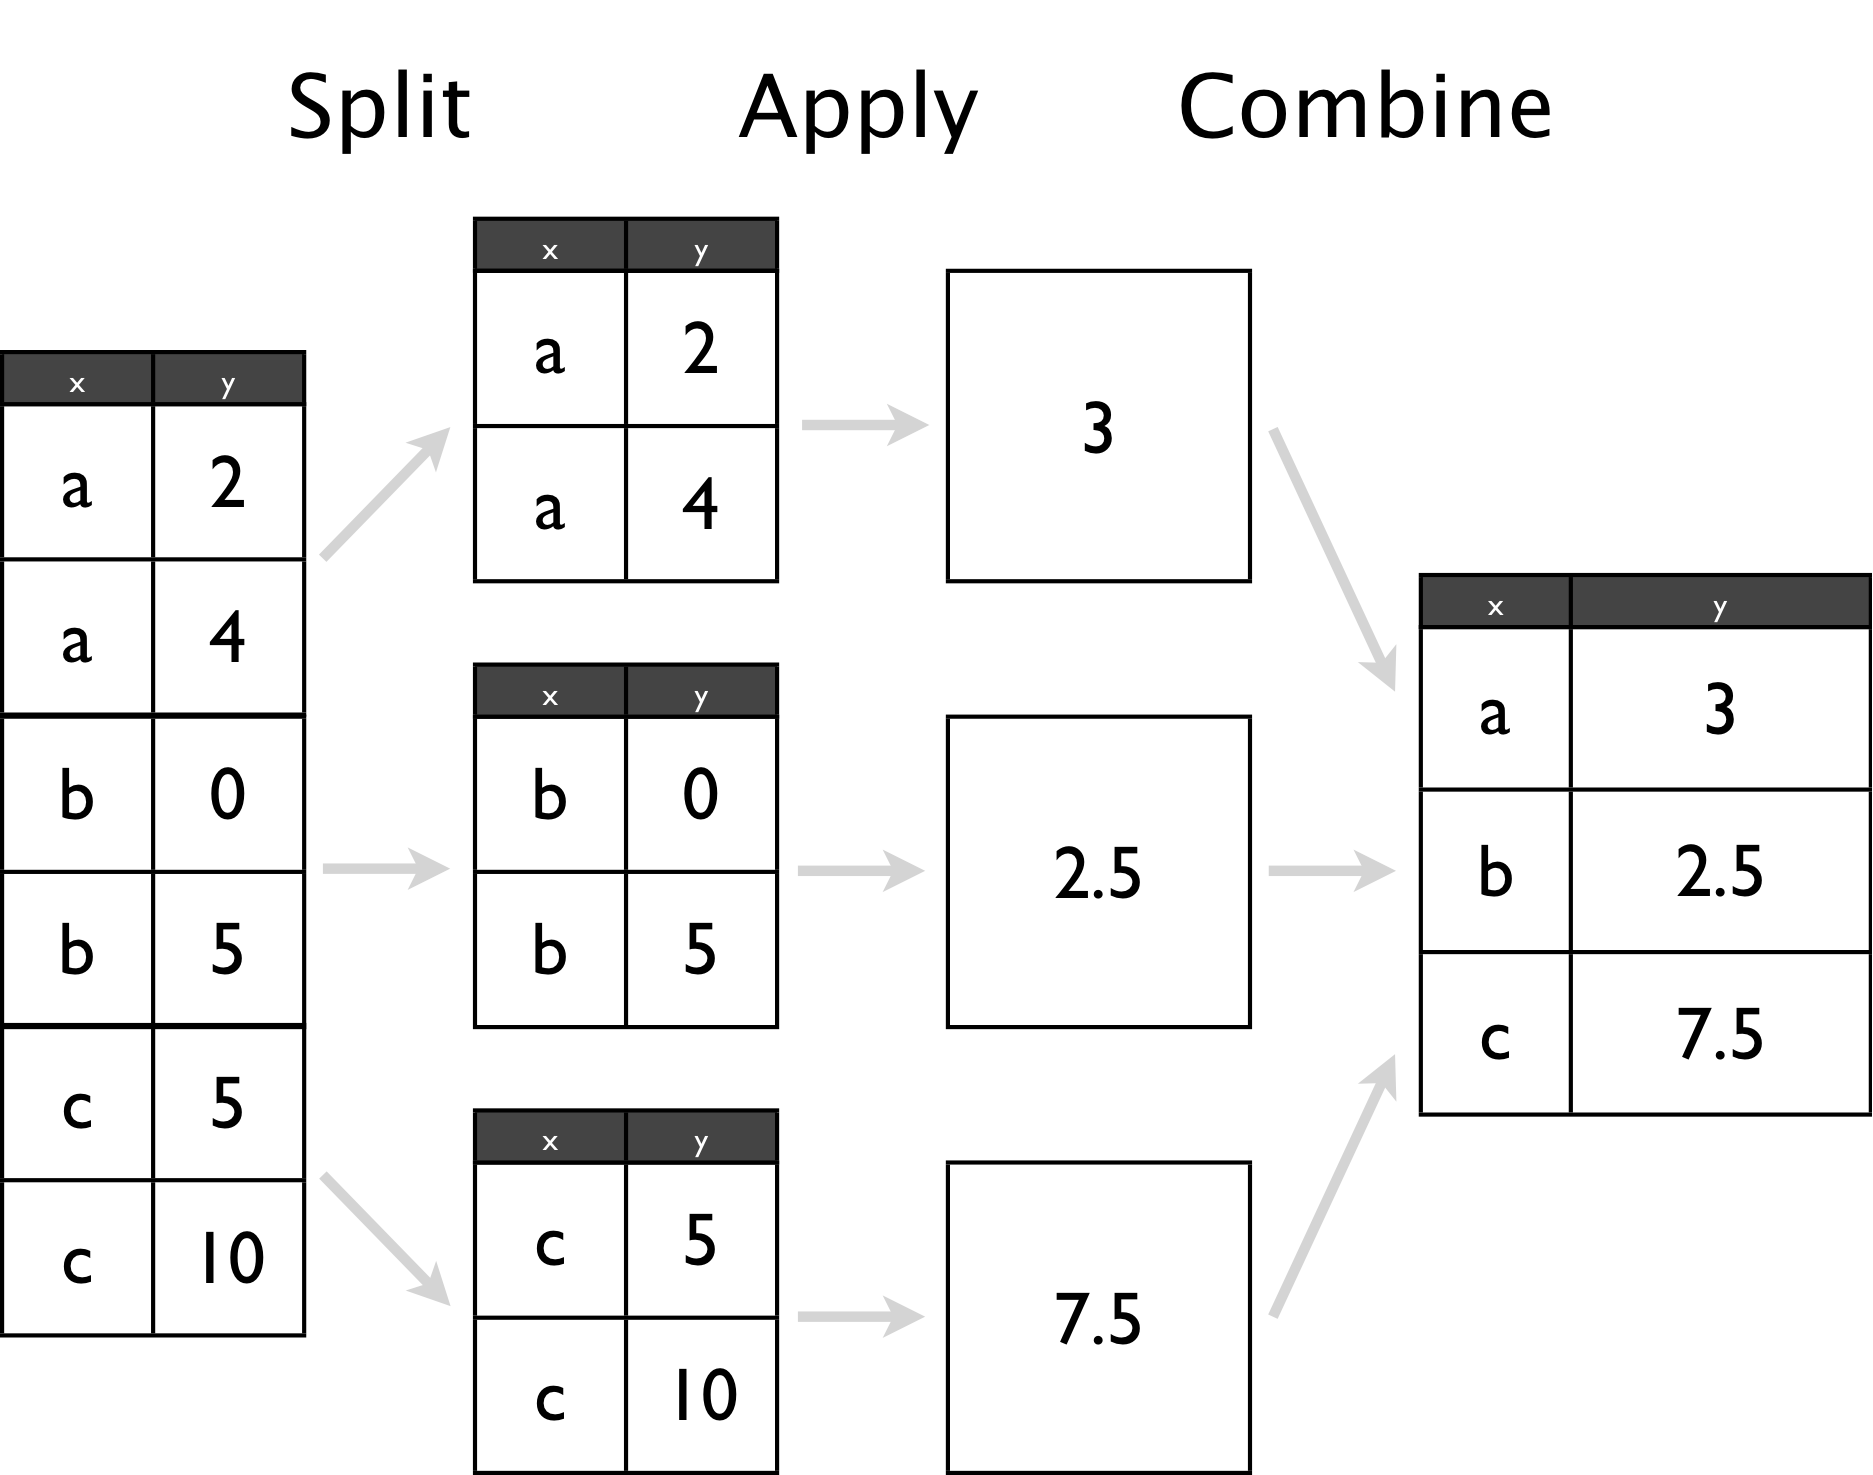

In [35]:
Image(filename='images/split-apply-combine.png', width=500)

In [55]:
sst = dset[['sst']]

In [37]:
sst

<xray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 806, zlev: 1)
Coordinates:
  * lat      (lat) float32 -88.0 -86.0 -84.0 -82.0 -80.0 -78.0 -76.0 -74.0 -72.0 -70.0 -68.0 ...
  * zlev     (zlev) float32 0.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 10.0 12.0 14.0 16.0 18.0 20.0 22.0 24.0 26.0 28.0 ...
  * time     (time) datetime64[ns] 1948-02-15 1948-03-15 1948-04-15 1948-05-15 1948-06-15 ...
Data variables:
    sst      (time, zlev, lat, lon) float64 nan nan nan nan nan nan nan nan nan nan nan nan nan ...
Attributes:
    title: ERSST V3b in situ only
    history: Wed Apr  8 09:45:04 2015: /usr/local/bin/ncrcat -O ersst.194802_ft.nc ersst.194803_ft.nc ersst.194804_ft.nc ersst.194805_ft.nc ersst.194806_ft.nc ersst.194807_ft.nc ersst.194808_ft.nc ersst.194809_ft.nc ersst.194810_ft.nc ersst.194811_ft.nc ersst.194812_ft.nc ersst.194901_ft.nc ersst.194902_ft.nc ersst.194903_ft.nc ersst.194904_ft.nc ersst.194905_ft.nc ersst.194906_ft.nc ersst.194907_ft.nc ersst.194908_ft.nc ersst.19

In [38]:
clim = sst.groupby('time.month').mean('time')

In [44]:
sst.close()

In [47]:
del(sst)

In [51]:
clim[['sst']]

<xray.Dataset>
Dimensions:  (lat: 89, lon: 180, month: 12, zlev: 1)
Coordinates:
  * lat      (lat) float32 -88.0 -86.0 -84.0 -82.0 -80.0 -78.0 -76.0 -74.0 -72.0 -70.0 -68.0 ...
  * zlev     (zlev) float32 0.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 10.0 12.0 14.0 16.0 18.0 20.0 22.0 24.0 26.0 28.0 ...
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (month, zlev, lat, lon) float64 nan nan nan nan nan nan nan nan nan nan nan nan nan ...

In [52]:
from calendar import month_name

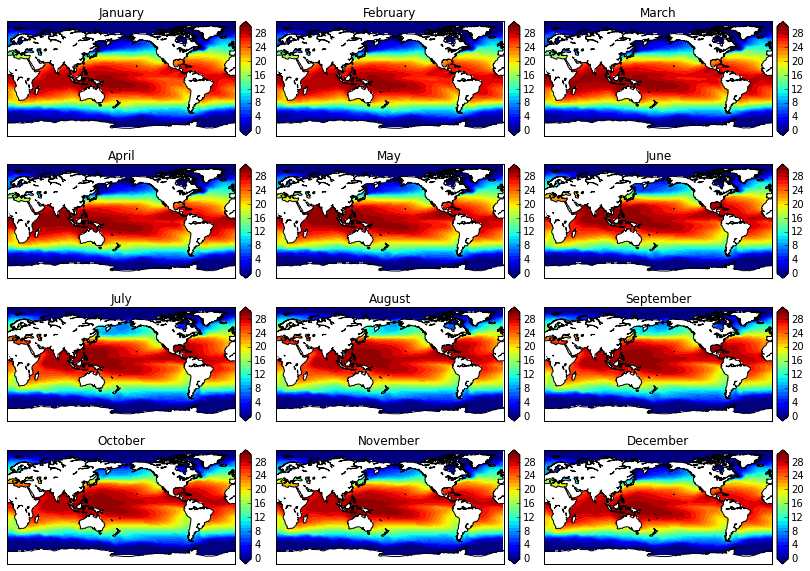

In [53]:
f, axes = plt.subplots(nrows=4,ncols=3, figsize=(14,10))
f.subplots_adjust(hspace=0.1, wspace=0.1)
axes = axes.flatten()
for i, month in enumerate(xrange(1,13)): 
    ax = axes[i]
    plot_field(clim['sst'][i,0,:,:].values, lats, lons, 0, 30, 1, ax=ax, title=month_name[month])
f.savefig('./images/clim_sst.png')

### New in version 0.4 (RC1 at 27/02/2015): calculates a seasonal (DJF, MAM, ...) climatology

In [56]:
seas_clim = sst.groupby('time.season').mean('time')

In [57]:
seas_clim

<xray.Dataset>
Dimensions:  (lat: 89, lon: 180, season: 4, zlev: 1)
Coordinates:
  * lat      (lat) float32 -88.0 -86.0 -84.0 -82.0 -80.0 -78.0 -76.0 -74.0 -72.0 -70.0 -68.0 ...
  * zlev     (zlev) float32 0.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 10.0 12.0 14.0 16.0 18.0 20.0 22.0 24.0 26.0 28.0 ...
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    sst      (season, zlev, lat, lon) float64 nan nan nan nan nan nan nan nan nan nan nan nan ...

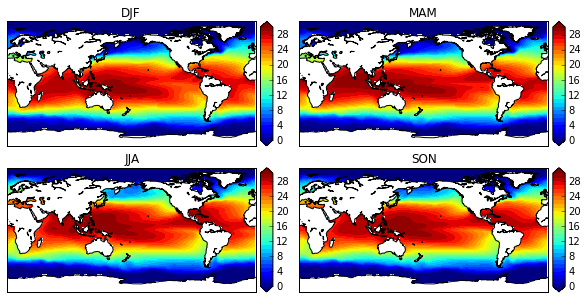

In [59]:
f, axes = plt.subplots(nrows=2,ncols=2, figsize=(10,5))
f.subplots_adjust(hspace=0.1, wspace=0.1)
axes = axes.flatten('F')
for i, seas in enumerate(seas_clim['season'].values): 
    ax = axes[i]
    plot_field(seas_clim['sst'][i,0,:,:].values, lats, lons, 0, 30, 1, ax=ax, title=seas)
f.savefig('./images/seas_clim_sst.png')

### calculates seasonal averages weigthed by the number of days in each month

adapted from [http://xray.readthedocs.org/en/stable/examples/monthly-means.html#monthly-means-example](http://xray.readthedocs.org/en/stable/examples/monthly-means.html#monthly-means-example)

In [5]:
def get_dpm(time):
    """
    return a array of days per month corresponding to the months provided in `time`
    """
    import calendar as cal
    month_length = np.zeros(len(time), dtype=np.float)

    for i, (month, year) in enumerate(zip(time.month, time.year)):
        month_length[i] = cal.monthrange(year, month)[1]
    return month_length

In [ ]:
def season_mean(ds, calendar='standard'):
    # Make a DataArray of season/year groups
    year_season = xray.DataArray(ds.time.to_index().to_period(freq='Q-NOV').to_timestamp(how='E'),
                                 coords=[ds.time], name='year_season')

    # Make a DataArray with the number of days in each month, size = len(time)
    month_length = xray.DataArray(get_dpm(ds.time.to_index()),
                                  coords=[ds.time], name='month_length')
    # Calculate the weights by grouping by 'time.season'
    weights = month_length.groupby('time.season') / month_length.groupby('time.season').sum()

    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(weights.groupby('time.season').sum().values, np.ones(4))

    # Calculate the weighted average
    return (ds * weights).groupby('time.season').sum(dim='time')

In [ ]:
sst_seas = season_mean(sst)

In [ ]:
sst_seas

In [ ]:
f, axes = plt.subplots(nrows=2,ncols=2, figsize=(10,5))
f.subplots_adjust(hspace=0.1, wspace=0.1)
axes = axes.flatten('F')
for i, seas in enumerate(seas_clim['time.season'].values): 
    ax = axes[i]
    plot_field(seas_clim['sst'][i,0,:,:].values, lats, lons, 0, 30, 1, ax=ax, title=seas)
f.savefig('./images/seas_clim_sst.png')

#### difference between non-weigthed and weighted seasonal climatologies

In [ ]:
diff_seas = seas_clim - sst_seas

In [ ]:
f, axes = plt.subplots(nrows=2,ncols=2, figsize=(10,5))
f.subplots_adjust(hspace=0.1, wspace=0.1)
axes = axes.flatten('F')
for i, seas in enumerate(seas_clim['time.season'].values): 
    ax = axes[i]
    plot_field(diff_seas['sst'][i,0,:,:].values, lats, lons, -0.1, 0.1, 0.01, ax=ax, title=seas)

### calculates anomalies with respect to a specific climatological *normal*

#### 1. defines the function

In [60]:
def demean(x): 
    return x - x.sel(time=slice('1981-1-15','2010-12-15')).mean('time')

#### 2. apply the function to the groupby object

In [62]:
#sst_anoms = dset.groupby('time.month').apply(demean)

# or (will return a xray.DataArray)

sst_anoms = dset['sst'].groupby('time.month').apply(demean) 

#### should be very similar to the original anomalies

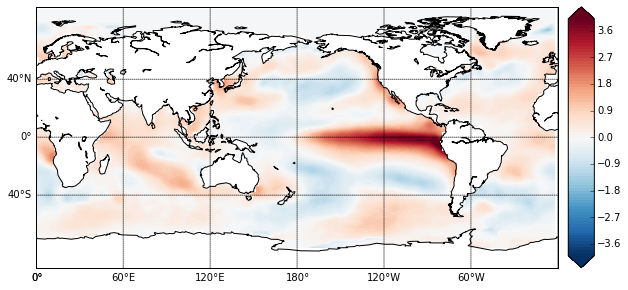

In [65]:
plot_field(sst_anoms.sel(time=('1998-1-15'), zlev=0), lats, lons, -4, 4, 0.1, \
           cmap=plt.get_cmap('RdBu_r'), grid=True)

### dumps a xray.Dataset object into a netcdf (Version 4) file (note: does not work for a xray.DataArray object)

In [70]:
sst_anoms = sst_anoms.to_dataset('sst_anoms')

In [71]:
sst_anoms

<xray.Dataset>
Dimensions:    (lat: 89, lon: 180, time: 806, zlev: 1)
Coordinates:
  * lat        (lat) float32 -88.0 -86.0 -84.0 -82.0 -80.0 -78.0 -76.0 -74.0 -72.0 -70.0 -68.0 ...
  * zlev       (zlev) float32 0.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 10.0 12.0 14.0 16.0 18.0 20.0 22.0 24.0 26.0 ...
  * time       (time) datetime64[ns] 1948-02-15 1948-03-15 1948-04-15 1948-05-15 1948-06-15 ...
Data variables:
    sst_anoms  (time, zlev, lat, lon) float64 nan nan nan nan nan nan nan nan nan nan nan nan ...

In [72]:
sst_anoms.to_netcdf('../data/ersst_anoms.nc')

In [ ]:
!ncdump -h ../data/ersst_anoms.nc

### Creates a xray dataset object from numpy arrays

In [ ]:
lon = np.linspace(0, 357.5, 144, endpoint=True)
lat = np.linspace(-90,90, 73, endpoint=True)

lons, lats = np.meshgrid(lon,lat)

lev = np.array([1000,925,850])
time = pd.date_range(start='2015-1-1',end='2015-1-3')

In [ ]:
arr = np.random.randn(3,3,73,144)

The dictionnary **keys** are the **variables** contained in the Dataset.<br><br>
The Dictionnary **values** are **tuples**, with first the (or the list of) dimension(s) over which the array varies, then the array itself

In [ ]:
d = {}
d['time'] = ('time',time)
d['latitudes'] = ('latitudes',lat)
d['longitudes'] = ('longitudes', lon)
d['level'] = ('level', lev)
d['dummy'] = (['time','level','latitudes','longitudes'], arr)

In [ ]:
dset = xray.Dataset(d)

In [ ]:
dset

In [ ]:
dset.sel(time='2015-1-2', level=1000)

In [ ]:
lons, lats = np.meshgrid(dset['longitudes'], dset['latitudes'])

In [ ]:
plot_field(dset.sel(time='2015-1-2', level=1000)['dummy'], \
           lats, lons, -4, 4, 0.1, grid=True)

In [ ]:
dset.to_netcdf('../outputs/dset_from_dict.nc')

In [ ]:
!ncdump -h ../outputs/dset_from_dict.nc

### Creates a xray dataset object from a Pandas DataFrame

In [ ]:
import string
df = pd.DataFrame(np.random.randn(365,5), \
                  index=pd.date_range(start='2014-1-1', periods=365), \
                  columns=list(string.ascii_letters[:5]))

In [ ]:
df.head()

#### from DataFrame

In [ ]:
df_ds = xray.Dataset.from_dataframe(df)

In [ ]:
df_ds

In [ ]:
group = df_ds.groupby('index.month').mean('index')

In [ ]:
group

#### converts TO a Pandas.DataFrame

In [ ]:
group_df = group.to_dataframe()

In [ ]:
group_df.reindex_axis(list(string.ascii_letters[:5]), axis=1).head()

In [ ]:
df.groupby(df.index.month).mean().head()

### Opening a file throught the network with openDAP

In [ ]:
url = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/interp_OLR/olr.day.mean.nc'

In [ ]:
olr_dset = xray.open_dataset(url)

In [ ]:
olr_dset

#### the dataset is not loaded in memory until one _selects_ something

In [ ]:
olr_sub = olr_dset.sel(time='1998-1-1',lat=slice(30,-30), lon=slice(170, 300))

In [ ]:
olr_sub

In [ ]:
m = bm(projection='merc',llcrnrlat=-30,urcrnrlat=30,\
            llcrnrlon=170,urcrnrlon=300,\
            lat_ts=0,resolution='c')

In [ ]:
lons, lats = np.meshgrid(olr_sub['lon'], olr_sub['lat'])

In [ ]:
plot_field(olr_sub['olr'].values, lats, lons, 80, 300, 10, grid=True)